# Examples:

In [27]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
%autoreload 2

In [29]:
# imports n stuff
import seaborn as sns
%matplotlib inline
from hardworking_memory import *
from utils import *
stylize()

### Specifying the common parameters (between match and nomatch conditions)

In [30]:
frange = (1, 20, 2) # range of frequencies to be used (min, max, step)
n_events = 2        # number of events per stimulus
t_events = 100      # duration of each event, so each duration of stimulus = t_events*n_events
t_response = 100    # duration of response
t_delay = 200       # duration of delay between source stimulus and target stimulus
y_labels = ["Signal",
            "Cue",
            "Correct response",
            "Condition's cue"]

# parameters for the event generator.
func_kw = {"event_duration": t_events}
transformation_kw = {"frequency_range":frange}

# parameters for the stimulus generator. 
#    it'll be qualitatively same for both here. 
#    you can use different functions for source and target generator,
#    I don't know yet why you might want to though.
source_generator_kw = {"function": make_step,
                       "function_kw": {"event_duration": t_events},
                       "frequencies":None}
target_generator_kw = source_generator_kw.copy()

# parameters for the trial generator
trial_kw = {"source_generator":make_stimulus,
            "source_generator_kw":source_generator_kw,
            "target_generator":make_stimulus,
            "target_generator_kw":target_generator_kw,
            "t_response":t_response,
            "t_silence":t_delay,
            "global_noise":.0}


## Producing a block of working memory task using the interface function. 
This calls other functions automatically and generates one block of trials given the parameters. Should be easier to use if you don't want the middle-steps (like the template).

What comes out of the next cell is a block of working memory task (not yet ready to be fed into a model, we'll get there in the end). So the match condition (not produced here) should be just the target signal being source but reversed in time (A,B,C --- C,B,A). No match condition is, well, the same but one event in the target is off (A,B,C --- C,D,A).

There will be 4 rows:


    1. the signal itself
    2. cue signal
    3. the correct response (match = 1, nomatch = -1)
    4. condition cue (recall = -1, wm = 1) 


In [31]:
# duration of each event is 100 so max frequency is 10, to be safe. (see make_sin's documentation)
block = hwm_interface(n_events=n_events,
                      frequency_range = (1,10,1),
                      event_function = make_sin,
                      transformation = scale_one_off,
                      n_trials = 100,
                      t_silence = t_delay,
                      t_response = t_response,
                      global_noise = 0.05,
                      is_retrograde = True,
                      is_wm = True,
                      is_match = False,
                      is_3d = True,
                      transformation_kw = transformation_kw,
                      function_kw = func_kw,
                      random_seed = 11)
print(block.shape)

(4, 100, 700)


<AxesSubplot:>

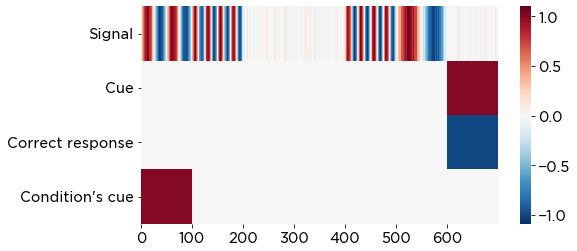

In [32]:
plt.figure(figsize=(8,4))
sns.heatmap(data = block[:,-1,:],
            center = 0,
            xticklabels=100,
            yticklabels=y_labels,
            cmap='RdBu_r')

## Producing blocks semi-manually


### 1.Specifying condition specific parameters
The transformation here is also scale_one_off that randomly changes the frequency of one event in the target signal. The new frequency is from the same frequency range. But here retrograde is False, which means the temporal order of target signal follows the source so a match condition is, for example, (A,B,C --- A,B,C) and a no match condition is (A,B,C --- A,B,D).

Since we have the frequency matrix, we can plot them using the simplified_plotter.

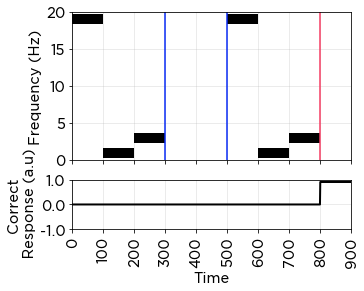

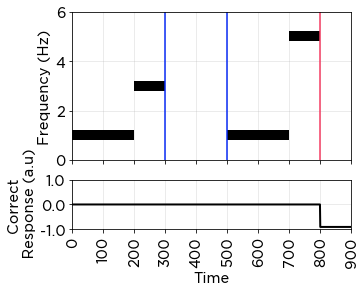

In [33]:
fix_random_seed(11)
match_frequencies = template_generator(n_trials = 60,
                                       n_events=3,
                                       transformation = None,
                                       frequency_range=frange,
                                       retrograde = False)

nomatch_frequencies = template_generator(n_trials = 40,
                                         n_events=3,
                                         transformation = scale_one_off,
                                         frequency_range = frange,
                                         transformation_kw= {"frequency_range":frange},
                                         retrograde = False)

match_fig = simplified_trial_plotter(match_frequencies[0],
                               t_delay=t_delay,
                               t_response=t_response,
                               t_events=t_events,
                               is_match=True,
                               figsize=(5,4))

nomatch_fig = simplified_trial_plotter(nomatch_frequencies[0],
                               t_delay=t_delay,
                               t_response=t_response,
                               t_events=t_events,
                               is_match=False,
                               figsize=(5,4))

### 2.Generating match conditions from the match template

In [34]:
match_block = experiment_generator(frequency_mat = match_frequencies,
                                   trial_generator = trial_generator,
                                   trial_generator_kw = trial_kw,
                                   is_wm=False,
                                   is_match=True,
                                   is_3d=True)

#the template is not bounded between 0 and 1 so... (the interface takes care of this automatically)
if source_generator_kw["function"] is make_step:
    match_block = normalize_step_signal(match_block,frange[1]) 

print(match_block.shape)

(4, 60, 900)


<AxesSubplot:>

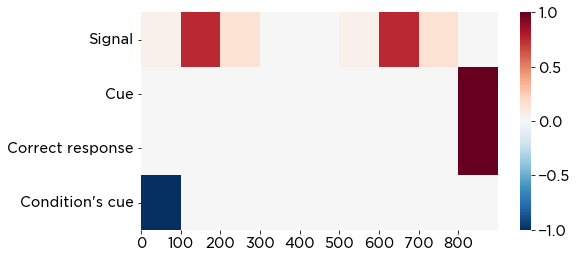

In [35]:
plt.figure(figsize=(8,4))
sns.heatmap(data = match_block[:,-1,:],
            center = 0,
            xticklabels=100,
            yticklabels=y_labels,
            cmap='RdBu_r')

### 3.Generate no match conditions

(4, 40, 900)


<AxesSubplot:>

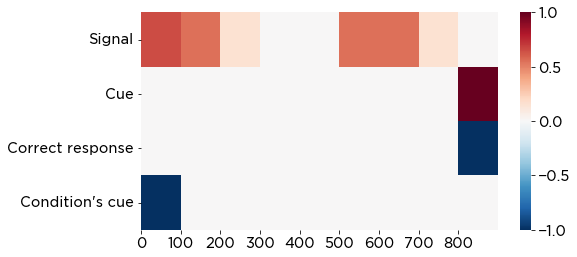

In [36]:
nomatch_block = experiment_generator(frequency_mat = nomatch_frequencies,
                                     trial_generator = trial_generator,
                                     trial_generator_kw = trial_kw,
                                     is_wm=False,
                                     is_match=False,
                                     is_3d=True)

if source_generator_kw["function"] is make_step:
    nomatch_block = normalize_step_signal(nomatch_block,frange[1])

print(nomatch_block.shape)
plt.figure(figsize=(8,4))
sns.heatmap(data = nomatch_block[:,-1,:],
            center = 0,
            xticklabels=100,
            yticklabels=y_labels,
            cmap='RdBu_r')

## Preparing the experiment
After we produced the blocks, either by the interface or kinda manually, we should prepare it for the model. train_test_preprocessor uses scikit learn to do the split but it shuffles trials itself, kinda like shuffling a deck of cards.

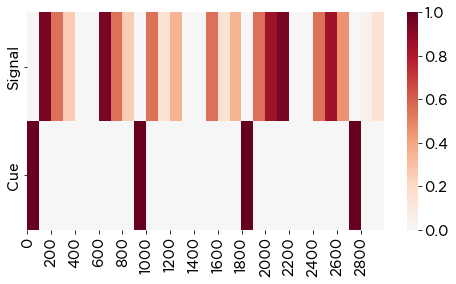

In [37]:
fix_random_seed(11)
sk_kw = {"test_size": .4, "shuffle":False}
X_train, X_test, y_train, y_test = train_test_preprocessor(match_block = match_block,
                                                          nomatch_block = nomatch_block,
                                                          **sk_kw)

plt.figure(figsize=(8,4))

sns.heatmap(data = X_train[2600:5600].T,
            center = 0,
            xticklabels=200,
            yticklabels=["Signal", "Cue"],
            cmap='RdBu_r')
plt.xlabel = "Time"

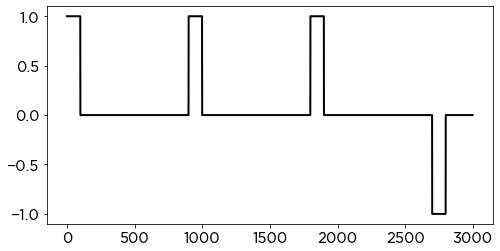

In [38]:
plt.figure(figsize=(8,4))
sns.lineplot(data = y_train[2600:5600],linewidth = 2, color = 'k')
plt.xlabel = "Time"

In [39]:
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}\n")
print(f"number of nomatch conditions in the training dataset: {int(np.count_nonzero(y_train == -1)/t_response)}")
print(f"number of nomatch conditions in the test dataset: {int(np.count_nonzero(y_test == -1)/t_response)}\n")
print(f"number of match conditions in the training dataset: {int(np.count_nonzero(y_train == 1)/t_response)}")
print(f"number of match conditions in the test dataset: {int(np.count_nonzero(y_test == 1)/t_response)}")

X_train: (54000, 2)
X_test: (36000, 2)
y_train: (54000,)
y_test: (36000,)

number of nomatch conditions in the training dataset: 25
number of nomatch conditions in the test dataset: 15

number of match conditions in the training dataset: 35
number of match conditions in the test dataset: 25
